<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-Introduction" data-toc-modified-id="1-Introduction-1">1 Introduction</a></span></li><li><span><a href="#2-Data-Access" data-toc-modified-id="2-Data-Access-2">2 Data Access</a></span></li><li><span><a href="#3-Extract-pixel-values" data-toc-modified-id="3-Extract-pixel-values-3">3 Extract pixel values</a></span></li><li><span><a href="#4-Pos-processing" data-toc-modified-id="4-Pos-processing-4">4 Pos-processing</a></span></li><li><span><a href="#5-Match-up-analysis" data-toc-modified-id="5-Match-up-analysis-5">5 Match-up analysis</a></span><ul class="toc-item"><li><span><a href="#5.1-Statistics" data-toc-modified-id="5.1-Statistics-5.1">5.1 Statistics</a></span></li><li><span><a href="#5.2-Graphical-analysis" data-toc-modified-id="5.2-Graphical-analysis-5.2">5.2 Graphical analysis</a></span></li></ul></li><li><span><a href="#6-Classification-performance-in-satellite-images" data-toc-modified-id="6-Classification-performance-in-satellite-images-6">6 Classification performance in satellite images</a></span><ul class="toc-item"><li><span><a href="#6.1-In-situ-e-satellite-match-up" data-toc-modified-id="6.1-In-situ-e-satellite-match-up-6.1">6.1 In situ e satellite match-up</a></span></li><li><span><a href="#6.2-In-situ-data-with-noise-added" data-toc-modified-id="6.2-In-situ-data-with-noise-added-6.2">6.2 In situ data with noise added</a></span></li></ul></li></ul></div>

# 1 Introduction
<br>
 The remote sensing reflectance (Rrs) was measured in situ in several sites and used as the ground truth. Sentinel-2 MSI images was obtained in the same sites of those measurements, which were atmospherically corrected using the AtmosPY software, based on 6SV transfer radiative model. Then, the Satellite MSI Rrs is compared with the in situ Rrs for evaluating its uncertainties of estimating Rrs. Measurements with a maximum of 1 day of difference between in situ e Sentinel-2 MSI was used for comparison.

# 2 Data Access

In [1]:
# library used
import pandas as pd
import datetime as dt
import pickle

# read data
insitu_db = pd.read_csv('00_Database/01_Tables/insitu_db.csv', index_col=0)[['date',
                                                                             'latitude',
                                                                             'longitude',
                                                                             'OWTs',
                                                                             'B2', 'B3', 'B4', 'B5','B6']].dropna()

# change the format of date column
insitu_db['date'] = [dt.date(int(x.split('-')[0]),
                             int(x.split('-')[1]),
                             int(x.split('-')[2])) for x in  insitu_db['date']]

# define the input data for classification test
msi = insitu_db[['B2', 'B3', 'B4', 'B5','B6']]
owts = insitu_db[['OWTs']]
owts_shape = owts.applymap(lambda x: x.replace('OWT 6', 'change').
              replace('OWT 7', 'change').
              replace('OWT 8', 'change').
              replace('change', 'OWT 678'))

test_ids = pd.read_csv('00_Database/02_Algorithms/test_ids.csv')['id']

# read classification algorithm
msi_svmc_alg = open('00_Database/02_Algorithms/msi_svmc_owts_alldataset.obj', 'rb') 
msi_svmc_alg = pickle.load(msi_svmc_alg)
msi_svmc_shape = msi_svmc_alg[0]
msi_svmc_678 = msi_svmc_alg[1]

In [2]:
insitu_db.head(3)

,date,latitude,longitude,OWTs,B2,B3,B4,B5,B6
0,2017-08-11,-2.06404,-55.4821,OWT 7,0.009979,0.016585,0.018798,0.016852,0.005857
1,2017-08-09,-2.27067,-55.4513,OWT 3,0.007854,0.014481,0.009707,0.013666,0.004066
2,2017-08-09,-2.26135,-55.3773,OWT 3,0.007792,0.013910,0.011931,0.011567,0.003631


In [3]:
msi_svmc_alg

[SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
     decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
     verbose=False)]

# 3 Extract pixel values
<br>
The extraction is done by a 3x3 pixel window, where the median is computed for comparing to in situ data

In [4]:
# library used
import os
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import *
from osgeo import osr
from pyproj import Proj, transform

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

#_______data input_____________
# path with all images
os.chdir('00_Database/03_Images/01_Match_ups/')

# The maximum time difference for comparison
dbuffer = dt.timedelta(days=1)

#______end of data input________

# create table for saving the match-ups
result = pd.DataFrame()

# interaction of all available image
for imageid in os.listdir():

    try:

        # dictionary for saving the extracted pixel values
        extractedvalues = {}
        
        # image id
        if imageid[0] == 'T':
            
            tileid = imageid.split('_')[0]
            timeid = imageid.split('_')[1]
            
        else:
            
            tileid = imageid.split('_')[9].split('B2B3B4B5b6')[0]
            timeid = imageid.split('_')[7]
            
        # image date
        imagedate = timeid.split('T')[0]
        imageyear = int(imagedate[0:4])
        imagemonth = int(imagedate[4:6])
        imageday = int(imagedate[6:8])
        imagedate = dt.date(imageyear, imagemonth, imageday)

        # date interval for searching in situ data
        dmin = (imagedate - dbuffer)
        dmax = (imagedate + dbuffer)
        
        # in situ ids in the date interval
        idsabovemin = insitu_db[insitu_db['date'] >= dmin]
        fieldids = idsabovemin[idsabovemin['date'] <= dmax]
        
        # read the latitude and longitude of in situ data
        fieldlat = fieldids.loc[:,'latitude']
        fieldlong = fieldids.loc[:,'longitude']

        # open the image using GDAL
        image = gdal.Open(imageid, GA_ReadOnly)
        
        # get the image epsg
        epsg = osr.SpatialReference(wkt=image.GetProjection()).GetAttrValue('AUTHORITY',1)
        
        # get the unit of coordinate system (metre or degree)
        unit = osr.SpatialReference(wkt=image.GetProjection()).GetAttrValue('UNIT',0)
        
        # get the image geotransform
        geotransform = image.GetGeoTransform()
        
        # get the number of rows in the image
        nrows = image.RasterYSize
        
        # get the number of columns in the image
        ncols = image.RasterXSize
        
        # get the initial long and lat
        long0 = geotransform[0]
        lat0 = geotransform[3]
        
        # get the pixel col and row sizes
        pixelcolsize = geotransform[1]
        pixelrowsize = geotransform[5]
        
        # saves in a dictionary the image bounding box
        bbox = {}
        bbox['lat0'] = lat0
        bbox['long0'] = long0
        bbox['latn'] = lat0+(nrows*pixelrowsize)
        bbox['longn'] = long0+(ncols*pixelcolsize)

        # convert the in situ coordinates system to the image coordinate system
        # the in situ coordinate system is the epsg:4326 for all samples
        if unit == 'metre':

            preserve_units = True
        else:

            preserve_units = False

        outProj = Proj(init='epsg:'+epsg, preserve_units=preserve_units)
        inProj = Proj(init='epsg:4326')

        newlatlong = {}
        
        for x in fieldlat.index:

            oldlat = fieldlat.loc[x]
            oldlong = fieldlong.loc[x]
            newlong, newlat = transform(inProj,outProj,oldlong,oldlat)
            newlatlong[x] = newlat, newlong
        
        # extract the row and column number of each sample
        pixelsloc = {}
        for x in fieldlat.index:

            latx = newlatlong[x][0]
            longx = newlatlong[x][1]
            if latx < bbox['lat0'] and latx > bbox['latn'] and longx > bbox['long0'] and longx < bbox['longn']:
                colloc = int((longx - bbox['long0'])/pixelcolsize) 
                rowloc = int((latx - bbox['lat0'])/pixelrowsize)
                pixelsloc[x] = rowloc, colloc
                
        # read all used bands
        satB2 = image.ReadAsArray()[0]
        satB3 = image.ReadAsArray()[1]
        satB4 = image.ReadAsArray()[2]
        satB5 = image.ReadAsArray()[3]
        satB6 = image.ReadAsArray()[4]
        
        # extract the median value of a 3x3 window for each band
        windowmedian = {}
        for x in fieldlat.index:
            
            for y in ['satB2', 'satB3', 'satB4', 'satB5', 'satB6']:
                
                try:

                    center11 = eval(y)[pixelsloc[x][0]-1, pixelsloc[x][1]-1]
                    center12 = eval(y)[pixelsloc[x][0]-1, pixelsloc[x][1]]
                    center13 = eval(y)[pixelsloc[x][0]-1, pixelsloc[x][1]+1]
                    center21 = eval(y)[pixelsloc[x][0], pixelsloc[x][1]-1]
                    center = eval(y)[pixelsloc[x][0], pixelsloc[x][1]]
                    center23 = eval(y)[pixelsloc[x][0], pixelsloc[x][1]+1]
                    center31 = eval(y)[pixelsloc[x][0]+1, pixelsloc[x][1]-1]
                    center32 = eval(y)[pixelsloc[x][0]+1, pixelsloc[x][1]]
                    center33 = eval(y)[pixelsloc[x][0]+1, pixelsloc[x][1]+1]

                    window = [center11, center12, center13, center21, center, center23, center31, center32, center33]
                    median = np.median(window)
                    windowmedian[y, x] = median

                except:
                    continue
                    
        # saves the extracted values in a pandas data frame

        if len(windowmedian.keys())>0:
            
            print('Image with match-up: ', imageid)
            
            for x in windowmedian.keys():

                extractedvalues[x[1], tileid, timeid, x[0]] = [x[1],
                                                               tileid,
                                                               timeid,
                                                               x[0],
                                                               windowmedian[x]]

            extractedvalues = pd.DataFrame(extractedvalues.values(),
                                           columns=['id', 'tile', 'time', 'band', 'median'])
            
            result = result.append(extractedvalues)
            
    except BaseException as e:
        print(f"Aqui deu erro: \n{str(e)}")


Image with match-up:  T21MXT_20170813T141259B2B3B4B5b6.tif
Image with match-up:  T22KGA_20180813T132229B2B3B4B5b6.tif
Image with match-up:  T21MYT_20170810T140049B2B3B4B5b6.tif
Image with match-up:  T22KFA_20180813T132229B2B3B4B5b6.tif
Image with match-up:  T21MZT_20170815T140051B2B3B4B5b6.tif
Image with match-up:  T21MYT_20170813T141259B2B3B4B5b6.tif
Image with match-up:  T21MYT_20170818T141301B2B3B4B5b6.tif
Image with match-up:  T20MKB_20170827T143751B2B3B4B5b6.tif
Image with match-up:  T21MYT_20170815T140051B2B3B4B5b6.tif
Image with match-up:  T21MYS_20170818T141301B2B3B4B5b6.tif
Image with match-up:  T21MXT_20170808T141051B2B3B4B5b6.tif


# 4 Pos-processing
<br>
Some match-ups may occur in clouds (0 values), in sites with adjacent effects (negative values), and with glint effects poorly removed. This pos-processing removes those match-ups and two outliers with no apparent inconsistency found. Moreover, the satellite Rrs is scaled by dividing it to 10000.

In [5]:
# create a match data frame
output = pd.DataFrame ()

for x in ['satB2', 'satB3', 'satB4', 'satB5', 'satB6']:
    
    subset = result[result['band'] == x][['id', 'median']]
    subset.columns = ['id', x]
    output = output.append(subset)
output = output.groupby('id').median()

match = output.join(insitu_db)

In [6]:
# removes negative and 0 values
match = match[match['satB2']>0]

In [7]:
# tag outlier values

outlier = {}
outlier[26] = 'High glint'
outlier[25] = 'High glint'
outlier[1] = 'Inconsistency not found'
outlier[264] = 'Adjacency effect'
outlier[2] = 'Inconsistency not found'
outlier[24] = 'Noisy image'
outlier[8] = 'Adjacent to clouds'
outlier[274] = 'Adjacency effect'
outlier[273] = 'Adjacency effect'
outlier[272] = 'Adjacency effect'
outlier[262] = 'Adjacency effect'
# remove outliers
match = match.drop(outlier.keys())

In [8]:
# scaled the satellite data
match[['satB2', 'satB3', 'satB4', 'satB5', 'satB6']] = match[['satB2', 'satB3', 'satB4', 'satB5', 'satB6']] / 10000

In [10]:
match

,satB2,satB3,satB4,satB5,satB6,date,latitude,longitude,OWTs,B2,B3,B4,B5,B6
id,,,,,,,,,,,,,,
6,0.00970,0.01900,0.0157,0.01790,0.00750,2017-08-12,-2.13744,-55.4869,OWT 3,0.009901,0.017612,0.016877,0.017380,0.006108
7,0.01330,0.02180,0.0180,0.02100,0.00930,2017-08-12,-2.11493,-55.4322,OWT 3,0.010950,0.019092,0.018019,0.018993,0.006981
14,0.00820,0.01230,0.0115,0.01000,0.00580,2017-08-09,-2.23914,-55.4971,OWT 3,0.008545,0.015200,0.010824,0.014561,0.005184
16,0.01310,0.02050,0.0263,0.02400,0.01130,2017-08-15,-2.30727,-54.4228,OWT 7,0.011355,0.019556,0.026049,0.023263,0.009127
17,0.01200,0.02020,0.0210,0.02230,0.00980,2017-08-15,-2.22649,-54.3651,OWT 7,0.010469,0.018522,0.022567,0.021037,0.007862
18,0.01255,0.02075,0.0196,0.02080,0.00925,2017-08-15,-2.22416,-54.2795,OWT 7,0.009647,0.017582,0.018035,0.018428,0.006843
19,0.01325,0.02045,0.0173,0.01955,0.00895,2017-08-15,-2.17863,-54.2197,OWT 3,0.010559,0.018632,0.016690,0.018058,0.006764
20,0.01720,0.02590,0.0303,0.02830,0.01360,2017-08-14,-2.30276,-54.1422,OWT 8,0.013764,0.022553,0.028270,0.026832,0.011693
151,0.00730,0.01270,0.0061,0.00830,0.00310,2018-08-12,-21.78430,-48.9627,OWT 4,0.006952,0.013574,0.006548,0.009393,0.003439


# 5 Match-up analysis

## 5.1 Statistics

In [11]:
# bias equation
bias = {}

for x in range(2,7):

    bias['B'+str(x)] = (((match['satB'+str(x)] -  match['B'+str(x)]) / match['B'+str(x)]))



In [12]:
# mean bias
print('Mean bias')
mean_bias = pd.DataFrame(bias).mean().round(2)
mean_bias

Mean bias


B2    0.14
B3    0.03
B4   -0.03
B5   -0.01
B6    0.21
dtype: float64

In [13]:
# std bias
print('Std bias')
std_bias = pd.DataFrame(bias).std().round(2)
std_bias

Std bias


B2    0.16
B3    0.11
B4    0.09
B5    0.13
B6    0.14
dtype: float64

In [14]:
# median bias
print('Median bias')
median_bias = pd.DataFrame(bias).median().round(2)
median_bias

Median bias


B2    0.16
B3    0.05
B4   -0.06
B5    0.03
B6    0.24
dtype: float64

In [15]:
# std bias
print('IQR bias')
iqr_bias = (pd.DataFrame(bias).quantile(0.75)-pd.DataFrame(bias).quantile(0.25)).round(2)
iqr_bias

IQR bias


B2    0.20
B3    0.16
B4    0.11
B5    0.16
B6    0.16
dtype: float64

In [16]:
# MAPE
print('MAPE')
mape = (abs(pd.DataFrame(bias)).mean()*100).round(0)
mape

MAPE


B2    19.0
B3    10.0
B4     7.0
B5    10.0
B6    23.0
dtype: float64

In [17]:
r_squared = {}

for x in range(2,7):
    
    r_squared['B'+str(x)] = (match.corrwith(match['B'+str(x)], method='pearson')['satB'+str(x)]**2)
    
print('R²')
pd.DataFrame(r_squared.values(), index=r_squared.keys(), columns=['R²']).round(2)

R²


,R²
B2,0.89
B3,0.94
B4,0.99
B5,0.96
B6,0.98


In [18]:
set(match['OWTs'])

{'OWT 3', 'OWT 4', 'OWT 7', 'OWT 8'}

## 5.2 Graphical analysis

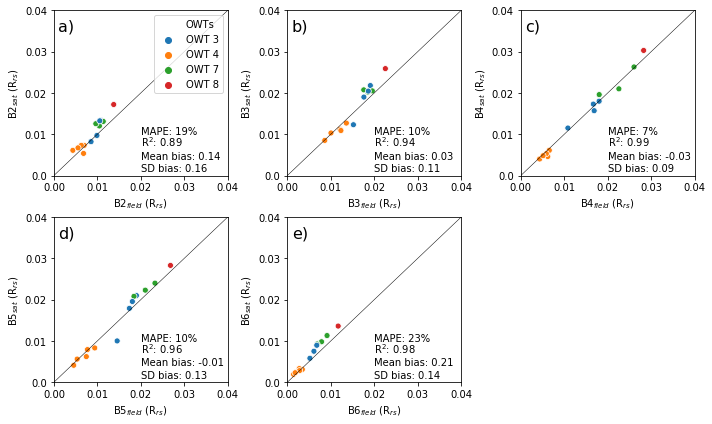

In [19]:
# library used
import seaborn as sns
import matplotlib.pyplot as plt

# plot
fig = plt.figure(figsize=(10, 6))

i = 1
for x, y in zip(range(2,7), ['a', 'b', 'c', 'd', 'e']):
    ax = plt.subplot(2,3,i)
    
    # set de legend only in the B2 graph
    if x == 2:
        leg = 'full'
        
    else:
        leg = False
        
    sns.scatterplot(y='satB'+str(x),
                    x='B'+str(x),
                    hue='OWTs',
                    legend=leg,
                    hue_order=['OWT 3', 'OWT 4', 'OWT 7', 'OWT 8'],
                    data=match,
                    color='k',
                    ax=ax)
    plt.plot([0, 1], color='black', linewidth=0.5)
    
    plt.ylabel('B'+str(x)+'$_{sat}$ (R$_{rs}$)')
    plt.xlabel('B'+str(x)+'$_{field}$ (R$_{rs}$)')

    ax.set_ylim(0,0.04)
    ax.set_xlim(0,0.04)
    
    plt.text(0.001, 0.035, y+')', fontsize=16)
    plt.text(0.02, 0.01, 'MAPE: '+str(int(mape['B'+str(x)]))+'%')
    plt.text(0.02, 0.007, 'R$^{2}$: '+str(np.round(r_squared['B'+str(x)], 2)))
    plt.text(0.02, 0.004, 'Mean bias: '+str(np.round(mean_bias['B'+str(x)], 2)))
    plt.text(0.02, 0.001, 'SD bias: '+str(np.round(std_bias['B'+str(x)], 2)))
    ax.set_yticks([0.0, 0.01, 0.02, 0.03, 0.04])
    ax.set_yticklabels([0.00, 0.01, 0.02, 0.03, 0.04])
    
    if x == 2:
        plt.legend(loc='upper right')
    
    i = i+1
    
plt.tight_layout(h_pad=0.3, w_pad=0.2)

In [20]:
os.chdir('..')
os.chdir('..')
fig.savefig('00_Figures/match_up.png', dpi=300)

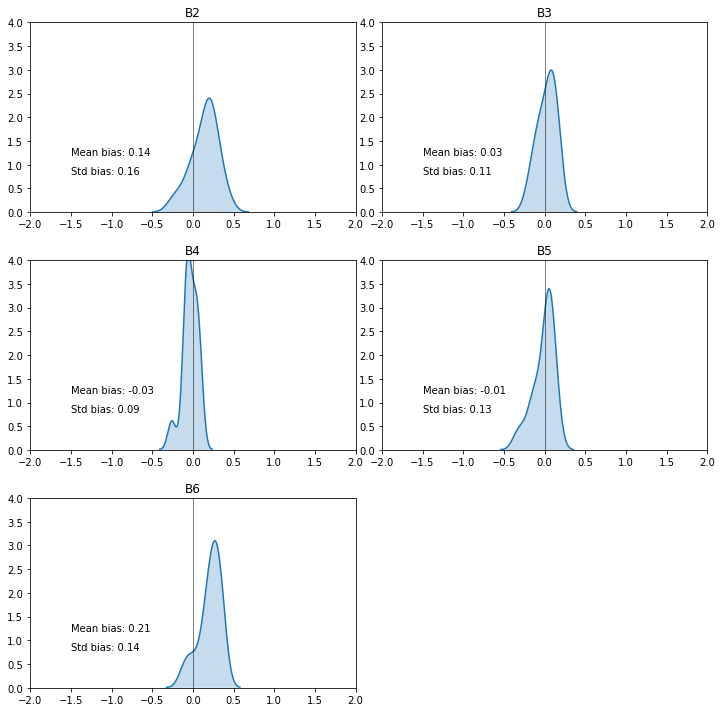

In [21]:
plt.figure(figsize=(10, 10))
i = 1
for x in range(2,7):
    
    band_mean_bias = mean_bias['B'+str(x)]
    std_mean_bias = std_bias['B'+str(x)]
    ax = plt.subplot(3,2,i)
    sns.kdeplot(bias['B'+str(x)], shade=True, ax=ax)
    ax.set_title('B'+str(x))
    ax.set_xlim(-2,2)
    ax.set_ylim(0,4)
    plt.plot([0, 0],[0,4], color='black', linewidth=0.5)
    ax.text(-1.5,1.2, 'Mean bias: '+str(band_mean_bias))
    ax.text(-1.5,0.8, 'Std bias: '+str(std_mean_bias))
    i = i+1
plt.tight_layout(h_pad=1.5, w_pad=0.5)

# 6 Classification performance in satellite images

## 6.1 In situ e satellite match-up

In [22]:
# library used
import copy as cp
from numpy.random import normal
from sklearn.metrics import balanced_accuracy_score

# define the test ids
test = match.index

# defines the true values of the test dataset
true = match.loc[test.values,'OWTs']

# add noise to bands
msi_noise = cp.copy(match[['satB2','satB3', 'satB4', 'satB5', 'satB6']])

# chooses the algorithm input
msi_norm = msi_noise.divide(msi.sum(axis=1), axis='rows')
msi_b3 = msi_noise[['satB3']]

# predict the OWTs in the test dataset (shape)
msi_svmc_predicted = msi_svmc_shape.predict(msi_norm.loc[test,:].values)
msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                  index=test,
                                  columns=['msi_predicted'])

# predict the OWTs in the test dataset (OWTs 7, 8, and 9)
msi_owt678_predicted_id = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == 'OWT 678'].index
msi_svmc_predicted_678 = msi_svmc_678.predict(msi_b3.loc[msi_owt678_predicted_id,:].values)
msi_svmc_predicted_678 = pd.DataFrame(msi_svmc_predicted_678,
                                      index=msi_owt678_predicted_id,
                                      columns=['msi_predicted'])

# concatenate all predicted OWTs
msi_svmc_predicted.update(msi_svmc_predicted_678)

# creates an evaluation dataset, concatenate predicted OWTs and the true OWTs
insitu_sat_msi_evaluation = msi_svmc_predicted.join(true)

# computes balanced accuracy, precision, and recall
correct_predictions = 0
for x in insitu_sat_msi_evaluation.index:
    
    ground_truth = insitu_sat_msi_evaluation.loc[x, 'OWTs']
    prediction = insitu_sat_msi_evaluation.loc[x, 'msi_predicted']
    
    if prediction == ground_truth:
        
        correct_predictions = correct_predictions+1

print('Correct predictions: ', str(correct_predictions), '/', str(len(insitu_sat_msi_evaluation)))

Correct predictions:  8 / 13


In [23]:
insitu_sat_msi_evaluation

,msi_predicted,OWTs
id,,
6,OWT 3,OWT 3
7,OWT 3,OWT 3
14,OWT 7,OWT 3
16,OWT 7,OWT 7
17,OWT 3,OWT 7
18,OWT 3,OWT 7
19,OWT 3,OWT 3
20,OWT 7,OWT 8
151,OWT 4,OWT 4


## 6.2 In situ data with noise added

In [25]:
# library used
import copy as cp
from numpy.random import normal
from sklearn.metrics import balanced_accuracy_score

# dictionaries for saving the accuracy results
msi_ba_dic = {}

for k in range(1,1000):

    # define the test ids
    test = test_ids

    # defines the true values of the test dataset
    true = owts.loc[test.values,:]

    # add noise to bands
    msi_noise = cp.copy(msi)
    msi_noise[['B2']] = msi_noise[['B2']].applymap(lambda x: x*normal(1+mean_bias['B2'], std_bias['B2']))
    msi_noise[['B3']] = msi_noise[['B3']].applymap(lambda x: x*normal(1+mean_bias['B3'], std_bias['B3']))
    msi_noise[['B4']] = msi_noise[['B4']].applymap(lambda x: x*normal(1+mean_bias['B4'], std_bias['B4']))
    msi_noise[['B5']] = msi_noise[['B5']].applymap(lambda x: x*normal(1+mean_bias['B5'], std_bias['B5']))
    msi_noise[['B6']] = msi_noise[['B6']].applymap(lambda x: x*normal(1+mean_bias['B6'], std_bias['B6']))

    # chooses the algorithm input
    msi_norm = msi_noise.divide(msi.sum(axis=1), axis='rows')
    msi_b3 = msi_noise[['B3']]

    # predict the OWTs in the test dataset (shape)
    msi_svmc_predicted = msi_svmc_shape.predict(msi_norm.loc[test,:].values)
    msi_svmc_predicted = pd.DataFrame(msi_svmc_predicted,
                                      index=test,
                                      columns=['msi_predicted'])

    # predict the OWTs in the test dataset (OWTs 7, 8, and 9)
    msi_owt678_predicted_id = msi_svmc_predicted[msi_svmc_predicted['msi_predicted'] == 'OWT 678'].index
    msi_svmc_predicted_678 = msi_svmc_678.predict(msi_b3.loc[msi_owt678_predicted_id,:].values)
    msi_svmc_predicted_678 = pd.DataFrame(msi_svmc_predicted_678,
                                          index=msi_owt678_predicted_id,
                                          columns=['msi_predicted'])

    # concatenate all predicted OWTs
    msi_svmc_predicted.update(msi_svmc_predicted_678)

    # creates an evaluation dataset, concatenate predicted OWTs and the true OWTs
    msi_evaluation = msi_svmc_predicted.join(true)

    # computes balanced accuracy, precision, and recall
    msi_ba = balanced_accuracy_score(msi_evaluation['OWTs'],
                                     msi_evaluation['msi_predicted'])

    # saves the statistical results
    msi_ba_dic[k] = [k, msi_ba] 

# save results in dataframes
ba_noise = pd.DataFrame(msi_ba_dic.values(), columns=[ 'interaction', 'ba']).round(2)

In [26]:
print('ba mean: ', ba_noise.mean()['ba'].round(2))

ba mean:  0.78


In [27]:
print('ba std: ', ba_noise.std()['ba'].round(2))

ba std:  0.04
